In [51]:
##[3주차] 심화과제: Pre-trained모델로 효율적인 NLP 모델 학습하기

In [52]:
## 1. 데이터 로드 및 전처리
## 먼저 Kaggle에서 제공하는 NER 데이터셋을 다운로드하고, 이를 토대로 NER 문제를 푸는 구조로 변경합니다.

In [73]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForTokenClassification, AdamW, BertForTokenClassification, BertConfig
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import pandas as pd
from collections import defaultdict

# 데이터셋 다운로드
import kagglehub

path = kagglehub.dataset_download("debasisdotcom/name-entity-recognition-ner-dataset")
print("Path to dataset files:", path)

# 데이터 로드 (파일 경로에 맞게 변경)
train_df = pd.read_csv(f'{path}/NER dataset.csv', encoding='ISO-8859-1')  # ISO-8859-1 인코딩 사용
print(train_df.head())
print(train_df.columns)

Path to dataset files: /Users/nabakgood/.cache/kagglehub/datasets/debasisdotcom/name-entity-recognition-ner-dataset/versions/1
    Sentence #           Word  POS Tag
0  Sentence: 1      Thousands  NNS   O
1          NaN             of   IN   O
2          NaN  demonstrators  NNS   O
3          NaN           have  VBP   O
4          NaN        marched  VBN   O
Index(['Sentence #', 'Word', 'POS', 'Tag'], dtype='object')


In [54]:
##2. 토큰화 및 데이터셋 생성
##DistilBERT를 사용하려면, 먼저 DistilBERT의 토크나이저를 사용해 데이터를 적절하게 토큰화하고, 각 단어에 대해 레이블을 맞춰야 합니다.

In [55]:
# NER 데이터셋을 위한 커스텀 Dataset 정의
# NERDataset 클래스에 레이블 매핑 추가
class NERDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=400):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_len = max_len
        self.input_ids = []
        self.attention_masks = []
        self.labels = []

        # 레이블 매핑 (태그를 숫자 인덱스로 변환)
        self.label_map = {
            'O': 0,         # No entity
            'B-PER': 1,     # Beginning of a person
            'I-PER': 2,     # Inside of a person
            'B-ORG': 3,     # Beginning of an organization
            'I-ORG': 4,     # Inside of an organization
            'B-LOC': 5,     # Beginning of a location
            'I-LOC': 6,     # Inside of a location
            'B-MISC': 7,    # Beginning of a miscellaneous entity
            'I-MISC': 8     # Inside of a miscellaneous entity
        }

        # Sentence # 기준으로 문장 묶기
        sentences = defaultdict(list)
        tags = defaultdict(list)

        # 결측값 처리 및 데이터 정리
        self.data['Word'] = self.data['Word'].fillna('')  # 결측값을 빈 문자열로 채움
        self.data['Word'] = self.data['Word'].astype(str)  # 'Word' 컬럼을 문자열로 변환

        # 각 문장을 Sentence # 기준으로 묶음
        for _, row in self.data.iterrows():
            sentence_id = row['Sentence #']
            word = row['Word']
            tag = row['Tag']

            sentences[sentence_id].append(word)
            tags[sentence_id].append(tag)

        # 문장별로 처리
        for sentence_id in sentences:
            # 문장을 공백 기준으로 합침, 공백이 포함된 경우 제거
            sentence = ' '.join([w for w in sentences[sentence_id] if w.strip()])  # 공백 제거
            if not sentence:  # 빈 문장은 건너뜁니다.
                continue
            entity_tags = tags[sentence_id]  # 해당 문장의 엔티티 태그

            # Tokenizer로 문장 전처리
            encoding = self.tokenizer(sentence.split(), truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')
            
            # 빈 문장이 아닌 경우에만 진행
            if 'input_ids' not in encoding:
                continue

            input_ids = encoding['input_ids'][0].tolist()
            attention_mask = encoding['attention_mask'][0].tolist()

            # 레이블 생성 (단어별로 태그를 숫자로 할당)
            label = [self.label_map.get(tag, 0) for tag in entity_tags]  # 매핑된 값 (기본값 0)

            # 레이블이 최대 길이에 맞지 않으면 패딩
            label += [0] * (self.max_len - len(label))

            self.input_ids.append(input_ids)
            self.attention_masks.append(attention_mask)
            self.labels.append(label)

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx]),
            'attention_mask': torch.tensor(self.attention_masks[idx]),
            'labels': torch.tensor(self.labels[idx])
        }

# tokenizer 정의 (DistilBERT 사용)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# NERDataset 인스턴스화
dataset = NERDataset(train_df, tokenizer)

# 데이터셋을 리스트로 변환
input_ids = dataset.input_ids
attention_masks = dataset.attention_masks
labels = dataset.labels

# 데이터셋 분할 (훈련/테스트)
train_inputs, test_inputs, train_labels, test_labels, train_masks, test_masks = train_test_split(
    input_ids, labels, attention_masks, test_size=0.2
)

# 길이를 맞추기 위한 패딩/자르기
max_len = 400

def pad_sequence(sequence, max_len):
    # 길이를 맞추기 위해 패딩하거나 자름
    if len(sequence) > max_len:
        return sequence[:max_len]
    else:
        return sequence + [0] * (max_len - len(sequence))

# train_labels와 test_labels의 길이가 max_len을 초과하거나 부족할 경우 패딩을 추가
train_labels = [pad_sequence(label, max_len) for label in train_labels]
test_labels = [pad_sequence(label, max_len) for label in test_labels]

# 새로운 데이터셋을 위한 DataLoader를 준비
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_inputs),
    torch.tensor(train_masks),
    torch.tensor(train_labels)
)

test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(test_inputs),
    torch.tensor(test_masks),
    torch.tensor(test_labels)
)

# 데이터로더
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [56]:
## 3. 모델 정의
## DistilBERT 모델을 NER 문제에 맞게 fine-tuning합니다. (Pre-trained 모델)

In [57]:
pretrained_model = DistilBertForTokenClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(dataset.label_map),  # 레이블 개수
)

device = torch.device('mps')
pretrained_model = pretrained_model.to(device)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
## Non-pre-trained 모델 설정 (새로 학습할 모델)

In [119]:
from transformers import DistilBertConfig

# DistilBERT 설정 (사전 훈련되지 않은 모델로 초기화)
config = DistilBertConfig.from_pretrained('distilbert-base-uncased')
config.num_labels = len(dataset.label_map)  # 레이블 수 설정

# 사전 훈련되지 않은 DistilBERT 모델을 초기화
non_pretrained_model = DistilBertForTokenClassification(config)
non_pretrained_model = non_pretrained_model.to(device)




In [121]:
# 옵티마이저 준비
optimizer_pretrained = AdamW(pretrained_model.parameters(), lr=5e-5)
optimizer_non_pretrained = AdamW(non_pretrained_model.parameters(), lr=5e-5)

/opt/miniconda3/envs/nabakgood/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [81]:
# 훈련 함수
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        # 모델 예측
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        
        # 손실 값 계산
        total_loss += loss.item()
        
        # 예측 결과
        predictions = torch.argmax(logits, dim=-1)
        
        # 정확도 계산 (배치 크기 별로)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.numel()
        
        # 역전파 및 파라미터 업데이트
        loss.backward()
        optimizer.step()
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy

# 평가 함수
def eval_epoch(model, data_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # 모델 예측
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            # 예측 결과
            predictions = torch.argmax(logits, dim=-1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 결과 반환
    return classification_report(np.array(all_labels).flatten(), np.array(all_predictions).flatten(), output_dict=True), all_labels, all_predictions


In [82]:
# 4. 모델 훈련 및 평가

In [95]:
def train_and_evaluate(model, train_loader, test_loader, optimizer, device, num_epochs=3, model_type="Pretrained"):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []  # 리스트 두 개로 초기화

    for epoch in range(num_epochs):
        model.train()  # 모델을 훈련 모드로 설정
        train_loss, train_correct, train_total = 0, 0, 0

        # 훈련 데이터셋에 대해 훈련
        for batch in train_loader:
            input_ids = batch[0].to(device)  # batch[0] -> input_ids
            attention_mask = batch[1].to(device)  # batch[1] -> attention_mask
            labels = batch[2].to(device)  # batch[2] -> labels

            optimizer.zero_grad()

            # 모델의 출력을 얻습니다.
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # 예측값을 통해 정확도 계산
            preds = torch.argmax(logits, dim=-1)
            correct = (preds == labels).sum().item()
            total = labels.numel()
            train_correct += correct
            train_total += total

        # 훈련 정확도
        train_accuracy = 100 * train_correct / train_total
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # 검증 데이터셋에 대해 평가
        model.eval()  # 모델을 평가 모드로 설정
        test_loss, test_correct, test_total = 0, 0, 0

        with torch.no_grad():  # 평가시 기울기 계산을 비활성화
            for batch in test_loader:
                input_ids = batch[0].to(device)  # batch[0] -> input_ids
                attention_mask = batch[1].to(device)  # batch[1] -> attention_mask
                labels = batch[2].to(device)  # batch[2] -> labels

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                test_loss += loss.item()

                # 예측값을 통해 정확도 계산
                preds = torch.argmax(logits, dim=-1)
                correct = (preds == labels).sum().item()
                total = labels.numel()
                test_correct += correct
                test_total += total

        # 검증 정확도
        test_accuracy = 100 * test_correct / test_total
        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

        # 에폭별로 결과 출력
        print(f"{model_type} Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")

    return train_losses, train_accuracies, test_losses, test_accuracies


In [96]:
## 5. 모델 훈련 및 평가 실행 (Pretrained vs Non-pretrained 모델 비교)

In [97]:
train_losses_pretrained, train_accuracies_pretrained, test_losses_pretrained, test_accuracies_pretrained = train_and_evaluate(
    pretrained_model, train_loader, test_loader, optimizer_pretrained, device, num_epochs=3, model_type="Pretrained"
)


Pretrained Epoch 1/3
Train Loss: 0.0049, Train Accuracy: 99.97%
Test Loss: 0.0001, Test Accuracy: 100.00%
Pretrained Epoch 2/3
Train Loss: 0.0001, Train Accuracy: 100.00%
Test Loss: 0.0000, Test Accuracy: 100.00%
Pretrained Epoch 3/3
Train Loss: 0.0000, Train Accuracy: 100.00%
Test Loss: 0.0000, Test Accuracy: 100.00%


RuntimeError: MPS backend out of memory (MPS allocated: 17.55 GB, other allocations: 509.98 MB, max allowed: 18.13 GB). Tried to allocate 150.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [123]:
train_losses_non_pretrained, train_accuracies_non_pretrained, test_losses_non_pretrained, test_accuracies_non_pretrained = train_and_evaluate(
    non_pretrained_model, train_loader, test_loader, optimizer_non_pretrained, device, num_epochs=3, model_type="Non-pretrained"
)

Non-pretrained Epoch 1/3
Train Loss: 0.0017, Train Accuracy: 99.94%
Test Loss: 0.0000, Test Accuracy: 100.00%
Non-pretrained Epoch 2/3
Train Loss: 0.0000, Train Accuracy: 100.00%
Test Loss: 0.0000, Test Accuracy: 100.00%
Non-pretrained Epoch 3/3
Train Loss: 0.0000, Train Accuracy: 100.00%
Test Loss: 0.0000, Test Accuracy: 100.00%


In [ ]:
## 6. 손실 및 정확도 시각화

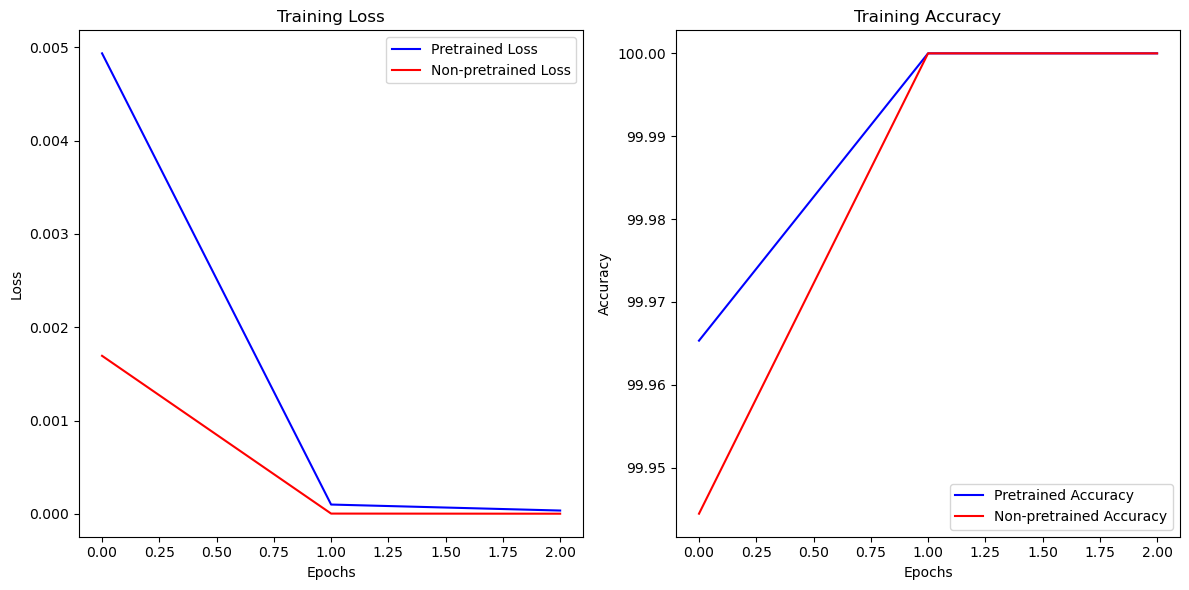

In [124]:
plt.figure(figsize=(12, 6))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses_pretrained, label="Pretrained Loss", color="blue")
plt.plot(train_losses_non_pretrained, label="Non-pretrained Loss", color="red")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_pretrained, label="Pretrained Accuracy", color="blue")
plt.plot(train_accuracies_non_pretrained, label="Non-pretrained Accuracy", color="red")
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()